<a href="https://colab.research.google.com/github/intel-analytics/BigDL/blob/branch-2.0/python/orca/colab-notebook/quickstart/autoxgboost_regressor_sklearn_boston.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

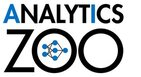
---

##### Copyright 2016 The BigDL Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
#

## **Environment Preparation**

**Install Java 8**

Run the cell on the **Google Colab** to install jdk 1.8.

**Note:** if you run this notebook on your computer, root permission is required when running the cell to install Java 8. (You may ignore this cell if Java 8 has already been set up in your computer).

In [ ]:
# Install jdk8
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
import os
# Set environment variable JAVA_HOME.
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
!update-alternatives --set java /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java
!java -version

**Install BigDL**

 

[Conda](https://docs.conda.io/projects/conda/en/latest/user-guide/install/) is needed to prepare the Python environment for running this example. 

**Note**: The following code cell is specific for setting up conda environment on Colab; for general conda installation, please refer to the [install guide](https://docs.conda.io/projects/conda/en/latest/user-guide/install/) for more details.

In [ ]:
import sys

# Set current python version
python_version = "3.7.10"

In [ ]:
# Install Miniconda
!wget https://repo.continuum.io/miniconda/Miniconda3-4.5.4-Linux-x86_64.sh
!chmod +x Miniconda3-4.5.4-Linux-x86_64.sh
!./Miniconda3-4.5.4-Linux-x86_64.sh -b -f -p /usr/local

# Update Conda
!conda install --channel defaults conda python=$python_version --yes
!conda update --channel defaults --all --yes

# Append to the sys.path
_ = (sys.path
        .append(f"/usr/local/lib/python3.7/site-packages"))

os.environ['PYTHONHOME']="/usr/local"

You can install the latest pre-release version using `pip install --pre --upgrade bigdl-orca[ray]`.

In [ ]:
# Install latest pre-release version of BigDL 
# Installing BigDL from pip will automatically install pyspark, bigdl, and their dependencies.
!pip install --pre --upgrade bigdl-orca

In [ ]:
# Install python dependencies
!pip install ray[tune]
!pip install xgboost==1.3.3
!pip install tensorboardx==2.2

## **Distributed Automl for xgboost using Orca AutoXGBoost**

Orca AutoXGBoost enables distributed automated hyper-parameter tuning for XGBoost, which includes `AutoXGBRegressor` and `AutoXGBClassifier` for sklearn `XGBRegressor` and `XGBClassifier` respectively. See more about [xgboost scikit-learn API](https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn).

In this guide we will describe how to use Orca AutoXGBoost for automated xgboost tuning in 4 simple steps.

## **Step 0: Prepare dataset**
We use [sklearn boston house-price dataset](https://scikit-learn.org/stable/datasets/toy_dataset.html#boston-dataset) for demonstration.  

In [ ]:
# load data 
from sklearn.datasets import load_boston

boston = load_boston()
y = boston['target']
X = boston['data']

In [ ]:
# split the data into train and test set 
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

### **Step 1: Init Orca Context**

In [ ]:
# import necesary libraries and modules
from __future__ import print_function
import os
import argparse

from bigdl.orca import init_orca_context, stop_orca_context
from bigdl.orca import OrcaContext

In [ ]:
# recommended to set it to True when running BigDL in Jupyter notebook. 
OrcaContext.log_output = True # (this will display terminal's stdout and stderr in the Jupyter notebook).

cluster_mode = "local"

if cluster_mode == "local":
    init_orca_context(cores=6, memory="2g", init_ray_on_spark=True) # run in local mode
elif cluster_mode == "k8s":
    init_orca_context(cluster_mode="k8s", num_nodes=2, cores=4, init_ray_on_spark=True) # run on K8s cluster
elif cluster_mode == "yarn":
    init_orca_context(
      cluster_mode="yarn-client", cores=4, num_nodes=2, memory="2g", init_ray_on_spark=True, 
      driver_memory="10g", driver_cores=1) # run on Hadoop YARN cluster

This is the only place where you need to specify local or distributed mode. View [Orca Context](https://bigdl.readthedocs.io/en/latest/doc/Orca/Overview/orca-context.html) for more details.

**Note**: You should export HADOOP_CONF_DIR=/path/to/hadoop/conf/dir when you run on Hadoop YARN cluster.

 ### **Step 2: Define Search space**




You should define a dictionary as your hyper-parameter search space for `XGBRegressor`. The keys are hyper-parameter names you want to search for `XGBRegressor`, and you can specify how you want to sample each hyper-parameter in the values of the search space. See [automl.hp](https://bigdl.readthedocs.io/en/latest/doc/PythonAPI/AutoML/automl.html#orca-automl-hp) for more details.


In [ ]:
from bigdl.orca.automl import hp

search_space = {
    "n_estimators": hp.grid_search([50, 100, 200]),
    "max_depth": hp.choice([2, 4, 6]),
}

### **Step 3: Automatically fit and search with Orca AutoXGBoost**



 

We will then fit AutoXGBoost automatically on [Boston Housing dataset](https://scikit-learn.org/stable/datasets/toy_dataset.html#boston-dataset).


First create an `AutoXGBRegressor`. 
You could also pass the sklearn `XGBRegressor` parameters to `AutoXGBRegressor`. Note that the `XGBRegressor` parameters shouldn't include the hyper-parameters in `search_space` or `n_jobs`, which is the same with `cpus_per_trial`.

In [ ]:
from bigdl.orca.automl.xgboost import AutoXGBRegressor

auto_xgb_reg = AutoXGBRegressor(cpus_per_trial=2, 
                                name="auto_xgb_classifier",
                                min_child_weight=3,
                                random_state=2)

Next, use the auto xgboost regressor to fit and search for the best hyper-parameter set.

In [ ]:
auto_xgb_reg.fit(data=(X_train, y_train),
                 validation_data=(X_test, y_test),
                 search_space=search_space,
                 n_sampling=2,
                 metric="rmse")

### **Step 4: Get best model and hyper parameters**


You can get the best learned model from the fitted auto xgboost regressor, which is an sklearn `XGBRegressor` instance.

In [ ]:
best_model = auto_xgb_reg.get_best_model()

You can also get the best hyper-parameter set.

In [ ]:
best_config = auto_xgb_reg.get_best_config()
print(best_config)

Then, you can use the best learned model as you want. Here, we demonstrate how to predict and evaluate on the test dataset.

In [ ]:
y_pred = best_model.predict(X_test)

from sklearn.metrics import mean_squared_error
print(mean_squared_error(y_test, y_pred))

In [ ]:
# stop orca context when program finishes
stop_orca_context()